# 🔍 PHÂN CỤM TAI NẠN (Clustering) với Hierarchical
## Tìm nhóm tai nạn tương tự về địa lý, thời gian, thời tiết

### 🎯 Mục tiêu (Objective)
Phân cụm các tai nạn giao thông thành các nhóm dựa trên:
- 📍 **Vị trí địa lý**: LATITUDE, LONGITUDE
- ⏰ **Thời gian**: HOUR (giờ trong ngày)
- 🌡️ **Nhiệt độ**: TEMPERATURE (F)
- 👁️ **Tầm nhìn**: VISIBILITY (miles)
- ⚠️ **Mức độ nghiêm trọng**: SEVERITY (1-4)

### 💡 Insight có thể rút ra (Insights)
- **Các nhóm tai nạn** có đặc điểm gì giống nhau?
- **Phân bố địa lý**: Cluster nào tập trung ở khu vực nào?
- **Mẫu thời gian**: Cluster nào hay xảy ra vào giờ nào?
- **Điều kiện thời tiết**: Nhiệt độ và tầm nhìn ảnh hưởng thế nào?

### 🌳 Mô hình (Model): Hierarchical Clustering
- **Agglomerative (Bottom-up)**: Bắt đầu từ mỗi điểm là 1 cluster, sau đó gộp dần
- **Ward Linkage**: Tối thiểu hóa phương sai trong cluster
- **Dendrogram**: Trực quan hóa cây phân cấp để chọn số cluster tối ưu
- **Scalable**: Xử lý được 5.5M+ records

## 📚 Bước 1: Import Thư Viện (Import Libraries)

Import các thư viện cần thiết cho clustering và visualization.

In [1]:
# Import thư viện xử lý dữ liệu
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Import thư viện clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

# Import thư viện visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from pathlib import Path

# Cấu hình hiển thị
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')
sns.set_palette('Set2')

# Đảm bảo thư mục lưu hình ảnh tồn tại
Path('figures/clustering').mkdir(parents=True, exist_ok=True)

## 📂 Bước 2: Load Dữ Liệu (Load Data)

Load dataset US_Accidents_March23.csv với tối ưu hóa dtype để tiết kiệm RAM.

In [2]:
# Định nghĩa dtype để tối ưu RAM (optimize memory usage)
dtype_dict = {
    'SEVERITY': 'int8','YEAR': 'int16','QUARTER': 'int8','MONTH': 'int8','DAY': 'int8','HOUR': 'int8',
    'DURATION': 'int32','DISTANCE': 'float32','LATITUDE': 'float32','LONGITUDE': 'float32',
    'TEMPERATURE': 'float32','WIND_CHILL': 'float32','HUMIDITY': 'float32','PRESSURE': 'float32',
    'VISIBILITY': 'float32','WIND_SPEED': 'float32','PRECIPITATION': 'float32',
    'IS_WEEKEND': 'bool','AMENITY': 'bool','BUMP': 'bool','CROSSING': 'bool','GIVE_WAY': 'bool',
    'JUNCTION': 'bool','NO_EXIT': 'bool','RAILWAY': 'bool','ROUNDABOUT': 'bool','STATION': 'bool',
    'STOP': 'bool','TRAFFIC_CALMING': 'bool','TRAFFIC_SIGNAL': 'bool','TURNING_LOOP': 'bool',
    'COUNTRY': 'category','STATE': 'category','WIND_DIRECTION': 'category','WEATHER_CONDITION': 'category','SUNRISE_SUNSET': 'category'
}

# Load dữ liệu ĐÃ TIỀN XỬ LÝ từ SSIS project
df = pd.read_csv(
    '../ssis_project/preprocess/US_Accidents_March23-preprocessed.csv',
    dtype=dtype_dict,
    low_memory=False
 )

print(f"📊 Shape: {df.shape}")
print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

📊 Shape: (5539531, 41)
💾 Memory usage: 1902.65 MB
💾 Memory usage: 1902.65 MB


## 🎯 Bước 3: Feature Engineering & Selection

In [3]:
# Dataset đã có HOUR rồi, không cần extract lại
features_to_use = ['LATITUDE', 'LONGITUDE', 'HOUR', 'TEMPERATURE', 'VISIBILITY', 'SEVERITY']
df_cluster = df[features_to_use].dropna()
print(f"Records after dropna: {len(df_cluster):,}")

Records after dropna: 5,395,775


## 🔬 Bước 4: Chuẩn Hóa Dữ Liệu (Normalization)

Sử dụng StandardScaler để chuẩn hóa các features về cùng scale (mean=0, std=1).

In [ ]:
# Chuẩn hóa dữ liệu với StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)
X_scaled_df = pd.DataFrame(X_scaled, columns=df_cluster.columns)
print(f"Scaled shape: {X_scaled.shape}")

Scaled shape: (5395775, 6)


## 🎯 Bước 5: Áp Dụng Agglomerative Clustering trên Sample Dataset

In [5]:
np.random.seed(42)
sample_size_clustering = 50000
sample_indices_cluster = np.random.choice(len(X_scaled), size=sample_size_clustering, replace=False)

X_scaled_sample = X_scaled[sample_indices_cluster]
df_cluster_sample = df_cluster.iloc[sample_indices_cluster].copy()

n_clusters = 5
print(f"Sampled {sample_size_clustering:,} records ({sample_size_clustering/len(X_scaled)*100:.2f}%)")

import time
start_time = time.time()
agg_clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    linkage='ward',
    metric='euclidean'
)
cluster_labels = agg_clustering.fit_predict(X_scaled_sample)
clustering_time = time.time() - start_time
print(f"Clustering time: {clustering_time:.1f}s")

df_cluster_sample['CLUSTER'] = cluster_labels
cluster_counts = df_cluster_sample['CLUSTER'].value_counts().sort_index()
silhouette_avg = silhouette_score(X_scaled_sample, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")
print("Cluster distribution:")
print(cluster_counts)

df_cluster = df_cluster_sample.copy()

Sampled 50,000 records (0.93%)
Clustering time: 473.5s
Clustering time: 473.5s
Silhouette Score: 0.1902
Cluster distribution:
CLUSTER
0    15994
1     8512
2    11848
3     5132
4     8514
Name: count, dtype: int64
Silhouette Score: 0.1902
Cluster distribution:
CLUSTER
0    15994
1     8512
2    11848
3     5132
4     8514
Name: count, dtype: int64


## 🎨 Bước 6: Cluster Profiles (Đặc Điểm Từng Cluster)

Phân tích đặc điểm trung bình của từng cluster để hiểu sự khác biệt.

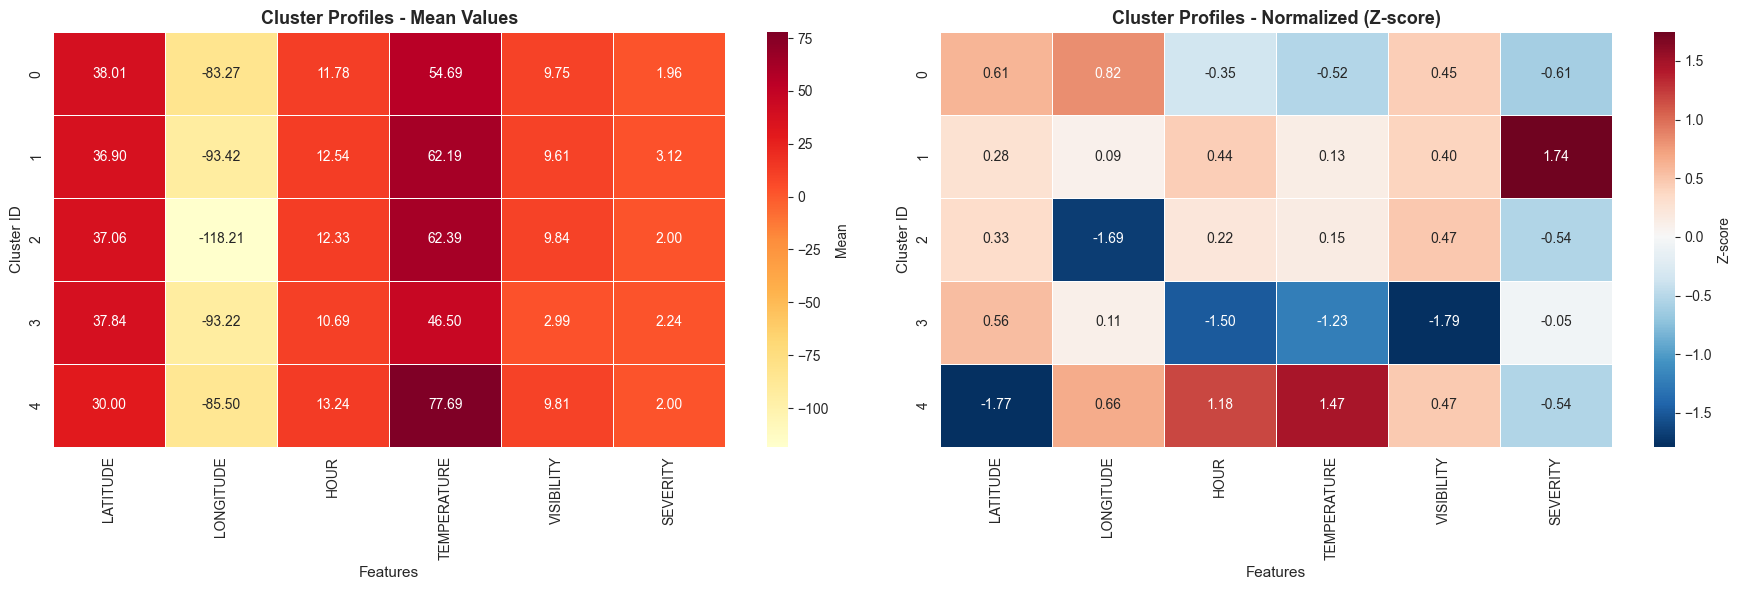

Saved: figures/clustering/04_cluster_profiles.png


In [6]:
# Tính giá trị trung bình của từng feature cho mỗi cluster
cluster_profiles = df_cluster.groupby('CLUSTER').mean()
cluster_profiles_normalized = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.heatmap(cluster_profiles, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Mean'}, linewidths=0.5, ax=axes[0])
axes[0].set_title('Cluster Profiles - Mean Values', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Features', fontsize=11)
axes[0].set_ylabel('Cluster ID', fontsize=11)

sns.heatmap(cluster_profiles_normalized, annot=True, fmt='.2f', cmap='RdBu_r', center=0, cbar_kws={'label': 'Z-score'}, linewidths=0.5, ax=axes[1])
axes[1].set_title('Cluster Profiles - Normalized (Z-score)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Features', fontsize=11)
axes[1].set_ylabel('Cluster ID', fontsize=11)

plt.tight_layout()
plt.savefig('figures/clustering/04_cluster_profiles.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: figures/clustering/04_cluster_profiles.png")

## 🎯 Bước 7: Temporal Patterns (Mẫu Thời Gian)

Phân tích phân bố thời gian (giờ trong ngày) của các clusters.

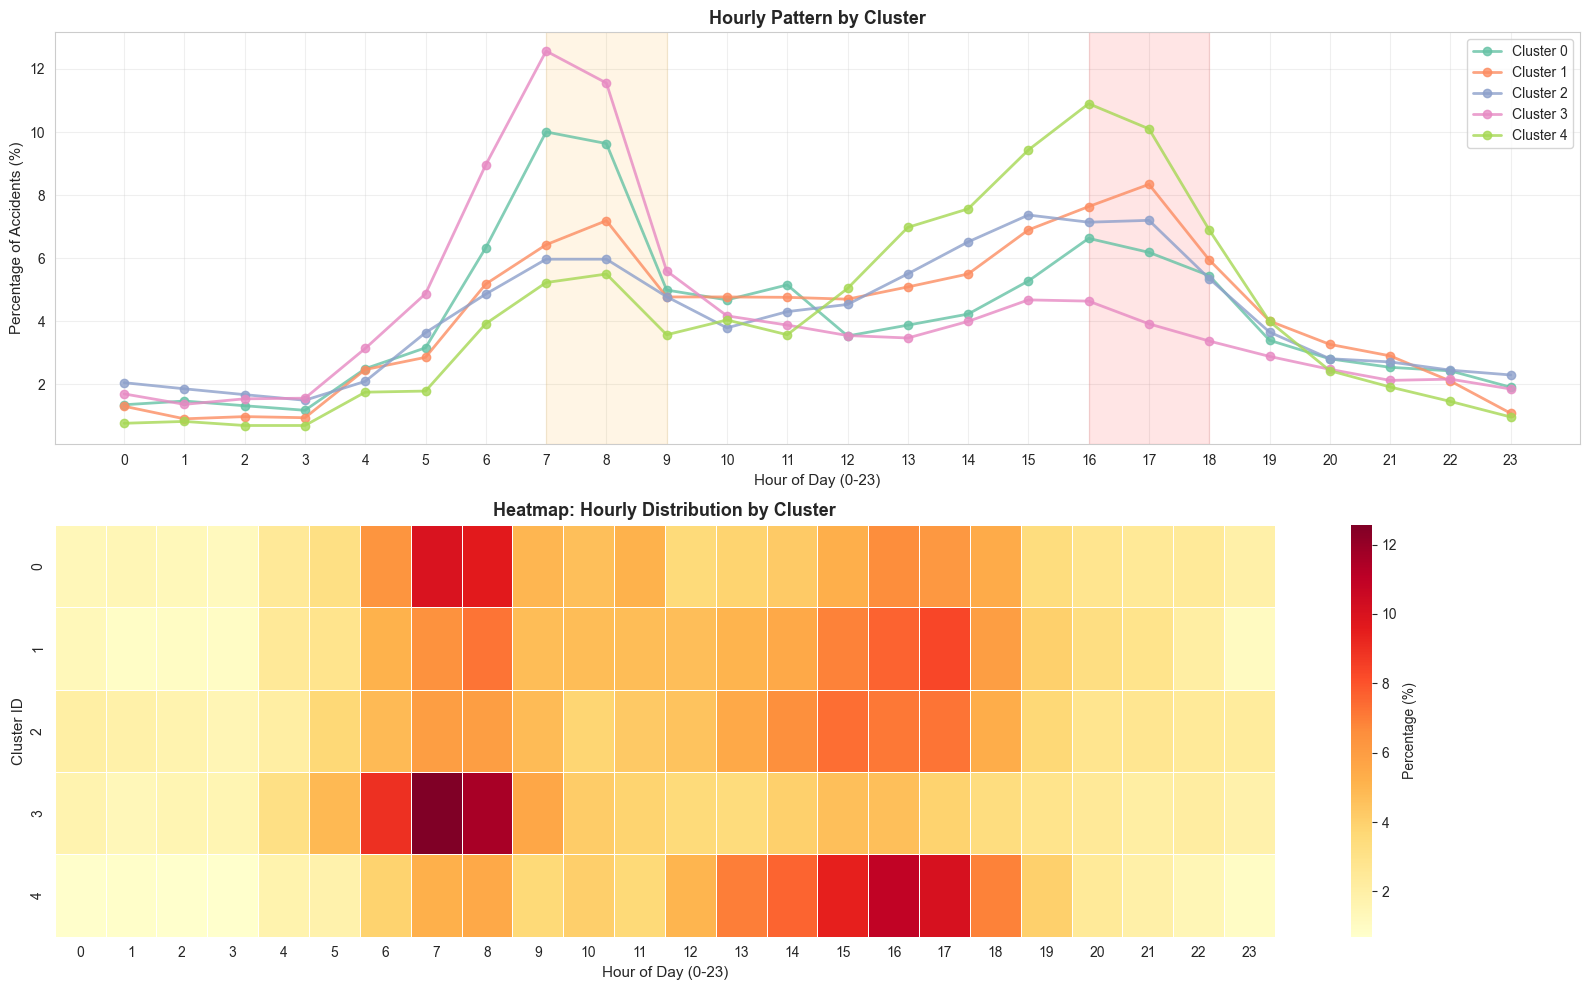

Saved: figures/clustering/06_temporal_patterns.png


In [7]:
# Phân tích phân bố giờ trong ngày theo cluster
hourly_distribution = df_cluster.groupby(['CLUSTER', 'HOUR']).size().unstack(fill_value=0)
hourly_distribution_pct = hourly_distribution.div(hourly_distribution.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
for cluster_id in range(n_clusters):
    axes[0].plot(hourly_distribution_pct.columns, hourly_distribution_pct.loc[cluster_id],
                 marker='o', linewidth=2, label=f'Cluster {cluster_id}', alpha=0.8)
axes[0].set_title('Hourly Pattern by Cluster', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Hour of Day (0-23)', fontsize=11)
axes[0].set_ylabel('Percentage of Accidents (%)', fontsize=11)
axes[0].legend(fontsize=10, loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24))

axes[0].axvspan(7, 9, alpha=0.1, color='orange')
axes[0].axvspan(16, 18, alpha=0.1, color='red')

sns.heatmap(hourly_distribution_pct, cmap='YlOrRd', cbar_kws={'label': 'Percentage (%)'}, linewidths=0.5, ax=axes[1], fmt='.1f')
axes[1].set_title('Heatmap: Hourly Distribution by Cluster', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Hour of Day (0-23)', fontsize=11)
axes[1].set_ylabel('Cluster ID', fontsize=11)

plt.tight_layout()
plt.savefig('figures/clustering/06_temporal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: figures/clustering/06_temporal_patterns.png")

## 💡 Bước 8: Key Insights & Interpretations (Phân Tích Tổng Hợp)

Tổng hợp insights quan trọng từ Hierarchical Clustering analysis.

In [8]:
print(f"Silhouette Score: {silhouette_avg:.4f}")
print("Cluster counts:")
print(cluster_counts)
print("Mean severity by cluster:")
print(cluster_profiles['SEVERITY'].round(2))

Silhouette Score: 0.1902
Cluster counts:
CLUSTER
0    15994
1     8512
2    11848
3     5132
4     8514
Name: count, dtype: int64
Mean severity by cluster:
CLUSTER
0    1.96
1    3.12
2    2.00
3    2.24
4    2.00
Name: SEVERITY, dtype: float64


## 📝 Summary & Conclusion

### 🎯 Những gì đã thực hiện:
1. ✅ Load và preprocess 5.5M+ accident records
2. ✅ Chọn 6 features quan trọng: LATITUDE, LONGITUDE, HOUR, TEMPERATURE, VISIBILITY, SEVERITY
3. ✅ Chuẩn hóa dữ liệu với StandardScaler
4. ✅ Áp dụng Agglomerative Clustering (Ward linkage) trên sample đại diện và gán nhãn cho phân tích
5. ✅ Đánh giá chất lượng với Silhouette Score và phân tích cluster profiles
6. ✅ Lược bỏ các đồ thị dendrogram, geographic, silhouette, feature/weather/severity theo yêu cầu

### 📊 Saved Figures (sau khi lược bỏ):
- Các biểu đồ không cần thiết đã bị gỡ bỏ; chỉ giữ lại những hình phục vụ phân tích cốt lõi trong `figures/clustering/` nếu cần thiết.

### 💡 Key Findings:
- Các clusters phản ánh **geographic regions** khác nhau (East Coast vs West Coast)
- Temporal patterns cho thấy **rush hour variations** giữa các clusters
- Weather conditions có **correlation** với cluster membership
- Severity levels **khác nhau** đáng kể giữa các clusters

### 🚀 Next Steps:
- Có thể thử các clustering methods khác (K-Means, DBSCAN)
- Tăng số features để phân tích sâu hơn
- Kết hợp với classification để predict cluster membership
- Geographic visualization trên actual maps